In [74]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models


import matplotlib.pyplot as plt

# Quanvolutional Neural Network testing

## Quanvolutional Layer

Define the quantum filter as a random quantum circuit (RQC) and build the routine to perfrom a quanvolution of a calssical 2d image.

In [3]:
dev = qml.device("default.qubit", wires=4)

# Random circuit parameters
n_layers = 4
n_qubits = 4  
rand_params = np.random.uniform(high=2*np.pi, size=(n_layers, n_qubits))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of classical input values
    for j in range(n_qubits):
        qml.RY(np.pi*phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(n_qubits)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]

In [4]:
def quanv(image, image_size, stride, kernel_size):
    """Convolves the input image with many applications of the same quantum circuit."""
    conv_size = int((image_size-kernel_size)/stride + 1)
    out = np.zeros((conv_size, conv_size, kernel_size**2))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, image_size, stride):
        for k in range(0, image_size, stride):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(kernel_size**2):
                out[j // kernel_size, k // kernel_size, c] = q_results[c]
    return out

### Convolutional Neural Network Model

In [49]:
def cnn_model(img_size = 28,
              channels = 1):
    cnn_model = models.Sequential([
        layers.Conv2D(filters=32, kernel_size=2, activation='relu', strides = (1,1), input_shape=(img_size, img_size, channels), data_format='channels_last'),
        #layers.MaxPooling2D((2, 2), strides = (2,2)),
        layers.Conv2D(filters=64, kernel_size=2, activation='relu', strides = (2,2)),
        layers.Conv2D(filters=64, kernel_size=2, activation='relu', strides = (2,2)),
        #layers.MaxPooling2D((2, 2), strides = (2,2)),
        layers.Flatten(),
        layers.Dense(100, activation='relu'),
        layers.Dense(10, activation='softmax')]
    )

    cnn_model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    return cnn_model

### Load data

In [19]:
n_train = 5000    # Size of the train dataset
n_valid = 150
n_test  = 2000    # Size of the test dataset


mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train-n_valid]
train_labels = train_labels[:n_train-n_valid]
valid_images = train_images[n_train-n_valid : n_train+n_valid]
valid_labels = train_labels[n_train-n_valid : n_train+n_valid]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

# reduce image resolution
train_images = tf.image.resize(train_images[:], (10,10)).numpy()
test_images = tf.image.resize(test_images[:], (10,10)).numpy()

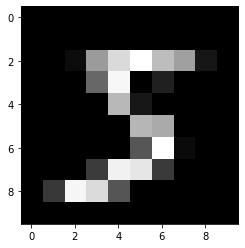

In [20]:
plt.imshow(train_images[0], cmap="gray")

### Train and evaluate classical model

In [82]:
cnn = cnn_model(
    img_size = 10
)
n_epochs = 40
#steps_per_epoch = 40
batch_size = 32

In [83]:
cnn_history = cnn.fit(train_images, train_labels,
                            #steps_per_epoch = steps_per_epoch,
                            #validation_data=(valid_images, valid_labels),
                            validation_split = 0.3,
                            batch_size=batch_size,
                            epochs=n_epochs, 
                            verbose=2)

Epoch 1/40
107/107 - 1s - loss: 1.2744 - accuracy: 0.6300 - val_loss: 0.5814 - val_accuracy: 0.8302 - 1s/epoch - 10ms/step
Epoch 2/40
107/107 - 1s - loss: 0.4230 - accuracy: 0.8677 - val_loss: 0.3396 - val_accuracy: 0.8990 - 549ms/epoch - 5ms/step
Epoch 3/40
107/107 - 1s - loss: 0.3128 - accuracy: 0.9054 - val_loss: 0.2981 - val_accuracy: 0.9086 - 554ms/epoch - 5ms/step
Epoch 4/40
107/107 - 0s - loss: 0.2546 - accuracy: 0.9202 - val_loss: 0.3199 - val_accuracy: 0.9072 - 457ms/epoch - 4ms/step
Epoch 5/40
107/107 - 0s - loss: 0.2089 - accuracy: 0.9358 - val_loss: 0.2577 - val_accuracy: 0.9155 - 480ms/epoch - 4ms/step
Epoch 6/40
107/107 - 0s - loss: 0.1762 - accuracy: 0.9432 - val_loss: 0.2618 - val_accuracy: 0.9168 - 458ms/epoch - 4ms/step
Epoch 7/40
107/107 - 0s - loss: 0.1582 - accuracy: 0.9549 - val_loss: 0.2328 - val_accuracy: 0.9278 - 455ms/epoch - 4ms/step
Epoch 8/40
107/107 - 0s - loss: 0.1329 - accuracy: 0.9594 - val_loss: 0.2444 - val_accuracy: 0.9265 - 437ms/epoch - 4ms/step
Ep

In [55]:
cnn_results = cnn.evaluate(test_images, test_labels, batch_size=batch_size, verbose=0, return_dict=True)

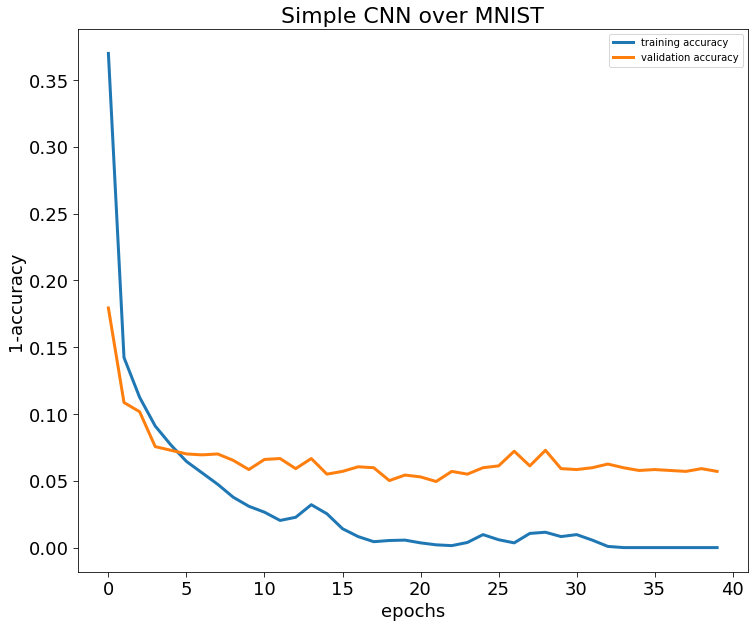

In [56]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.set_title("Simple CNN over MNIST",         fontsize=22)
ax.set_xlabel("epochs",     fontsize=18)
ax.set_ylabel("1-accuracy", fontsize=18)
ax.tick_params(axis="both", which="major", labelsize=18, length=5)
ax.grid

ax.plot(
    np.arange(0, n_epochs, 1), 1-np.array(cnn_history.history["accuracy"]),
    lw    = 3,
    label = "training accuracy"
)

ax.plot(
    np.arange(0, n_epochs, 1), 1-np.array(cnn_history.history["val_accuracy"]),
    lw    = 3,
    label = "validation accuracy"
)


ax.legend()

In [30]:
cnn_results

{'loss': 0.3596193790435791, 'accuracy': 0.9150000214576721}

### Add the quantum layer

In [32]:
# preprocess data
q_train_images = []
for img in train_images:
    q_train_images.append(quanv(img, 10, 2, 2))

In [33]:
q_train_images=np.array(q_train_images)

q_test_images = []
for img in test_images:
    q_test_images.append(quanv(img, 10, 2, 2))

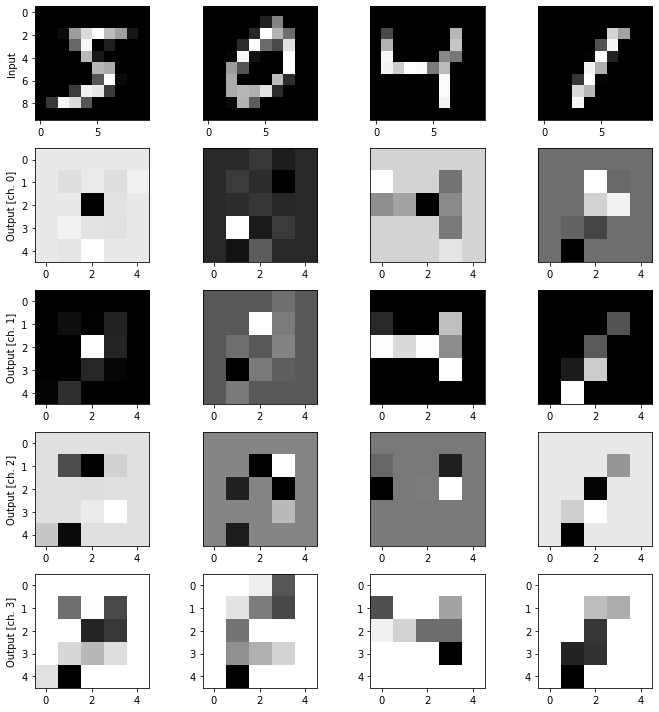

In [34]:
# Visualize some samples
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [78]:
q_cnn = cnn_model(
    img_size = 5, 
    channels = 4,
)

In [79]:
q_cnn_history = q_cnn.fit(q_train_images, train_labels,
                           # steps_per_epoch=steps_per_epoch,
                            batch_size=batch_size,
                            validation_split=0.3,
                            epochs=n_epochs, 
                            verbose=2)

Epoch 1/40
107/107 - 1s - loss: 1.8730 - accuracy: 0.3588 - val_loss: 1.4781 - val_accuracy: 0.4948 - 933ms/epoch - 9ms/step
Epoch 2/40
107/107 - 0s - loss: 1.2872 - accuracy: 0.5361 - val_loss: 1.2209 - val_accuracy: 0.5608 - 408ms/epoch - 4ms/step
Epoch 3/40
107/107 - 0s - loss: 1.1103 - accuracy: 0.6012 - val_loss: 1.1433 - val_accuracy: 0.5869 - 276ms/epoch - 3ms/step
Epoch 4/40
107/107 - 0s - loss: 0.9868 - accuracy: 0.6442 - val_loss: 1.0072 - val_accuracy: 0.6488 - 338ms/epoch - 3ms/step
Epoch 5/40
107/107 - 0s - loss: 0.8895 - accuracy: 0.6887 - val_loss: 0.9565 - val_accuracy: 0.6653 - 440ms/epoch - 4ms/step
Epoch 6/40
107/107 - 0s - loss: 0.8361 - accuracy: 0.7093 - val_loss: 0.8928 - val_accuracy: 0.6900 - 438ms/epoch - 4ms/step
Epoch 7/40
107/107 - 0s - loss: 0.7689 - accuracy: 0.7384 - val_loss: 0.8442 - val_accuracy: 0.7052 - 324ms/epoch - 3ms/step
Epoch 8/40
107/107 - 0s - loss: 0.7069 - accuracy: 0.7602 - val_loss: 0.8330 - val_accuracy: 0.6997 - 313ms/epoch - 3ms/step


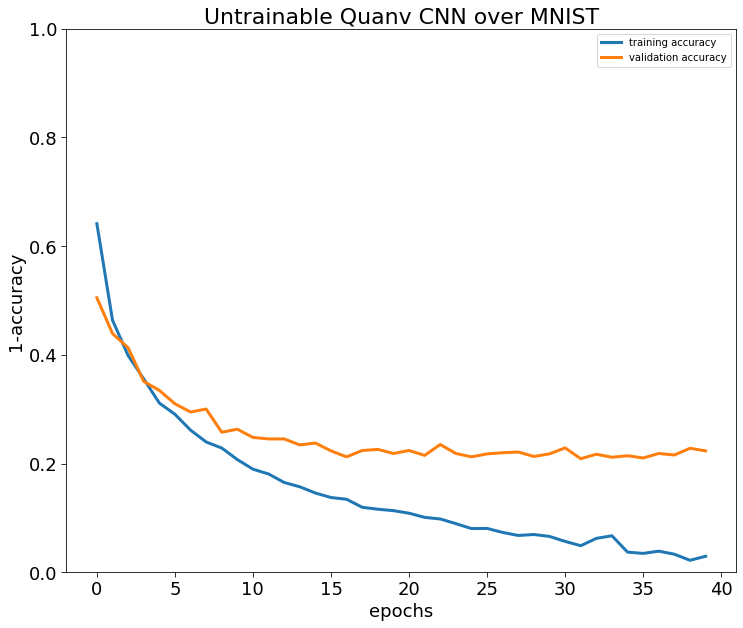

In [80]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.set_title("Untrainable Quanv CNN over MNIST",         fontsize=22)
ax.set_xlabel("epochs",     fontsize=18)
ax.set_ylabel("1-accuracy", fontsize=18)
ax.tick_params(axis="both", which="major", labelsize=18, length=5)
ax.grid

ax.plot(
    np.arange(0, n_epochs, 1), 1-np.array(q_cnn_history.history["accuracy"]),
    lw    = 3,
    label = "training accuracy"
)

ax.plot(
    np.arange(0, n_epochs, 1), 1-np.array(q_cnn_history.history["val_accuracy"]),
    lw    = 3,
    label = "validation accuracy"
)

ax.set_ylim(0,1)

ax.legend()

## 

AttributeError: 'list' object has no attribute 'history'

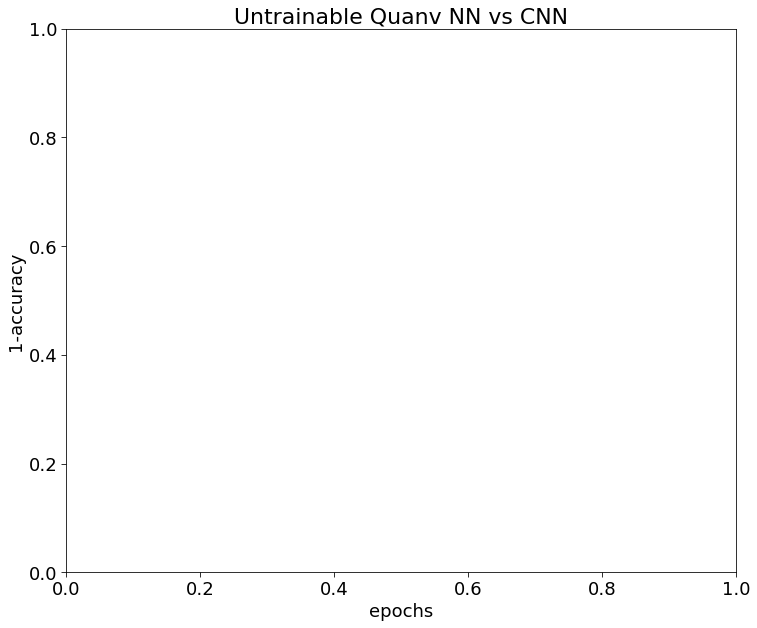

In [81]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.set_title("Untrainable Quanv NN vs CNN",         fontsize=22)
ax.set_xlabel("epochs",     fontsize=18)
ax.set_ylabel("1-accuracy", fontsize=18)
ax.tick_params(axis="both", which="major", labelsize=18, length=5)
ax.grid

ax.plot(
    np.arange(0, n_epochs, 1), 1-np.array(cnn_history.history["accuracy"]),
    lw    = 3,
    label = "convolutional model"
)

ax.plot(
    np.arange(0, n_epochs, 1), 1-np.array(q_cnn_history.history["accuracy"]),
    lw    = 3,
    label = "quanvolutional model"
)

ax.set_ylim(0,1)

ax.legend(
    fontsize=14
)

In [72]:
import pickle
with open('../qcnn_history.pickle', 'rb') as handle:
    q_cnn_history = pickle.load(handle)


In [73]:
with open('../cnn_history.pickle', 'rb') as handle:
    cnn_history = pickle.load(handle)